# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Filippo Conforto'
ID_number = int('2021856')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# Homework II - Reinforcement Learning with Jackblack

The following homework allows you to review many concepts from the course of Reinforcement Learning.

In particular you will have to implement Monte Carlo algorithm, SARSA-$\lambda$ and SARSA-$\lambda$ with action-value function approximation. In order to test the implementations, we need an environment. Therefore you need also to complete the given code for a modified version of Blackjack game seen in class. In a burst of creativity, we will call it **Jackblack** (with no reference to the actor).

Needed imports below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

random.seed(ID_number)
np.random.seed(ID_number)

NameError: name 'ID_number' is not defined

## Jackblack rules:

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)


- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of _red_ (probability 1/3) or _black_ (probability
2/3).


- There are no aces or picture (face) cards in this game (no issues with usable aces!)


- At the start of the game both the player and the dealer draw one black
card (fully observed)


- Each turn the player may either **stick** or **hit**:
    - If the player hits then he draws another card from the deck
    - If the player sticks he receives no further cards and its turn ends


- The values of the player’s cards are added (if black card) or subtracted (if red
card)


- If the player’s sum exceeds 21, or becomes less than 1, then he “goes
bust” and loses the game, with a reward of -1


- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins, with a reward of 1; otherwise, the outcome – _win_ (reward 1),
_lose_ (reward -1), or _draw_ (reward 0) – is given by the player with the largest sum.

## Implementation of Jackblack environment

Follow the instructions givenn in each function and implement the missing ones so that the environment will work as expected.

As it usually happens with games, where we receive only a signle reward at the end of the episode, we will assume that there is no discounting, i.e. $\gamma=1$. This will hold throughout the entire notebook (hence you will not see that parameter)!

In [5]:
class Jackblack():
    
    def __init__(self):
        """
        Init the environment with its inner variables.
        The first state by picking a random card for the dealer and player.
        """
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score}  # initial state
        self.actions = ("hit", "stick")
               
        init_state = self.state.copy()
        self.history = [init_state]  # game history, recording state and action of each step
        
        
    def step(self, action, verbose=False):
        """
        Compute a step in Easy21 game. 
        
        Parameters
        ----------
        action : string, the action to pick
        verbose : bool, if True actions are printed
        
        Returns
        -------
        state : dict, the new state reached given the picked action
        reward : int, the reward we get in this new state
        done : bool, True if state is terminal, False if not
        """
        self.history.append({"player": action})
        
        # player hits
        if action == "hit":
            value, colour = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, colour, self.state['player_score'])
            if verbose:
                print(f'Player draws {colour} {value}')
            
            new_state = self.state.copy()
            self.history.append(new_state)
            
            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1                
                if verbose:
                    print('Player goes bust')
                    print('Player loses')
                return self.state, reward, True
            
            else:
                reward = 0
                return self.state, reward, False
            
        # player sticks   
        else:
            if verbose:
                    print(f'Player stops')
            new_state = self.state.copy()
            self.history.append(new_state)
            
            state, reward = self.dealer_moves(verbose)
            return self.state, reward, True

        
    def draw_card(self): # TODO1
        """
        Each draw from the deck results in a value between 1 and 10 (uniformly
        distributed) with a colour of red (probability 1/3) or black (probability 2/3).
        
        Returns
        -------
        value : int, the value of the card
        colour : string, the colour of the card, "red" or "black"
        """
        # YOUR CODE HERE
        # Simple code returning a couple of values (cart value, cart color)
        return np.random.randint(1,11),np.random.choice(["red","black"],p=[1/3,2/3])
    
    
    def goes_bust(self, score): # TODO2
        """
        Check if the player/dealer went bust
        
        Parameters
        ----------
        score : int, the score to check
        
        Returns
        -------
        bool : True if score is outside the prescribed range
        """
        # YOUR CODE HERE
        # Simple expression returning true if the score satisfies the conditions
        return (score > 21) or (score < 1)
    
    
    def compute_new_score(self, value, colour, current_score): # TODO3
        """
        Compute the new score given the value and the colour of the drawn card.
        
        Parameters
        ----------
        value : int, the card's value
        colour : string, the card's colour
        current_score : int, the score to update
        
        Returns
        -------
        new_score : int, updated score
        """
        # YOUR CODE HERE
        # computing new score based on card colour
        if colour == "red":
            return current_score - value
        elif colour == "black":
            return current_score + value
    
    def dealer_moves(self, verbose=False): 
        """
        Fixed dealer policy.
        
        Parameters
        ----------
        verbose : bool, if True actions are printed
        
        Returns
        -------
        state : state, the terminal state of the whole game sequence
        reward : int, the reward obtained at the end of the game sequence
        """
        # dealer hits as long as his score is < 17
        while self.state['dealer_score'] < 17:
            value, colour = self.draw_card()
            self.state['dealer_score'] = self.compute_new_score(value, colour, self.state['dealer_score'])
            if verbose:
                print(f'Dealer draws {colour} {value}')
            
            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)
            
            
            if self.goes_bust(self.state['dealer_score']):
                # dealer goes bust, player wins
                if verbose:
                    print('Dealer goes bust')
                    print('Dealer loses')
                reward = 1
                return self.state, reward
            
        self.history.append({"dealer": "stick"})  
        
        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']  
        
        # score > 17 -> dealer sticks
        if verbose:
            print('Dealer stops')
        if dealer_score < player_score: # player wins
            reward = 1
            if verbose:
                print('Player wins')
            return self.state, reward                    
        if dealer_score == player_score: # draw
            reward = 0
            if verbose:
                print('Draw')
            return self.state, reward                 
        if dealer_score > player_score: # player loses
            reward = -1
            if verbose:
                print('Dealer wins')
            return self.state, reward
        
        
    def print_score(self):
        """
        Print the current score of the game, both for player and dealer.
        """
        print('----------------')
        for player in self.state.items():
            print(player[0] + ': ' + str(player[1]))
        print('----------------')
       

In [6]:
# AT THIS POINT THE ENVIRONMENT MUST BE COMPLETED!

Now explore some steps of a Jackblack game to check if the environment is coherent with the given rules. You can run the next cell multiple times.

In [7]:
env = Jackblack()
env.print_score()
env.step("hit", True)
env.print_score()
env.step("hit", True)
env.print_score()
env.step("stick", True)
env.print_score()

----------------
dealer_score: 3
player_score: 3
----------------
Player draws black 3
----------------
dealer_score: 3
player_score: 6
----------------
Player draws red 8
Player goes bust
Player loses
----------------
dealer_score: 3
player_score: -2
----------------
Player stops
Dealer draws black 3
Dealer draws red 3
Dealer draws red 8
Dealer goes bust
Dealer loses
----------------
dealer_score: -5
player_score: -2
----------------


In [8]:
env.step("hit", True)

Player draws red 5
Player goes bust
Player loses


({'dealer_score': -5, 'player_score': -7}, -1, True)

## Monte-Carlo Control of Jackblack

Let's implement the classical version of Monte Carlo algorithm for action-value functions in order to find a good policy to win over the dealer.

In [9]:
class MC_Control():
    
    
    def __init__(self, N_0=100, n_episodes=100, lr=None):
        """
        Init the Monte Carlo control class with its inner variables.
        Try to understand how the N_0 parameter works!
        Both the Q-table and the counter are initialized to zero.
        The first episode is played with a random policy.
        """
        self.actions = ("hit", "stick") 
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.lr = lr                    # The learning rate: "how much" the Q-function is updated at each step
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy
 

    def learn_q_value_function(self): # TODO4 (see other functions to understand how it should be done!)
        """
        Update the Q-function over all the episodes.
        From the second episode onwards you should use the epsilon greedy policy: see code below in order to
        understand how to do that!
        Pay attention to the <play_episode> function to understand how to implement this one!
        Do not forget to update both the Q-table and the counter.
        
        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """
        # YOUR CODE HERE
        # playing the choosen number of episodes
        for i in range(self.n_episodes):
            # initializing the reward sum
            G = 0
            # playing the episode 
            episode = self.play_episode()
            # looping over the episode backward
            for state,action,reward,done in episode[::-1]:
                G += reward
                self.increment_counter(state, action)
                self.update_Q(state,action,G)

    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  # initialize to 0 the Q-values!
            
        return lookup_table
        
    
    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Jackblack game sequence following the given policy. 
        
        Returns
        ----------
        episode : [(state, action, reward, done)], a list of (state, action, reward, done)
        """
        env = Jackblack()                # init a game sequence
        state = env.state.copy()         # init state
        episode = []                     # list of the steps of the game sequence
        done = False
        while not done:      
            # pick an action regarding the current state and policy
            action = self.get_action(state)
            next_state, reward, done = deepcopy(env.step(action))
            step = (state, action, reward, done)  # store previous state
            state = next_state
            episode.append(step)
            
        return episode


    def update_Q(self, state, action, total_reward):  # TODO5
        """
        Update Q value towards the target.
        Even if this function does not return anything, you need to update <self.Q>!
        
        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for that state-action pair
        """
        lookup_state = tuple(state.values())
        
        # The learning rate, decaying along with the number of times an action-state pair 
        # has been explored. It represents the amount of modification we want to bring to 
        # the Q value function.
        # YOUR CODE HERE
        # Updating the Q value function according to a learning rate or to a sample average
        if self.lr!=None:
            self.Q[lookup_state][action] += self.lr*(total_reward - self.Q[lookup_state][action])
        else:
            self.Q[lookup_state][action] += (total_reward - self.Q[lookup_state][action])/self.get_state_action_counter(state,action)

        
    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1
    
    
    def random_policy(self):  # TODO6
        """
        Return an action following a random policy (clearly state free).
        
        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        return np.random.choice(self.actions)
     
     
    def e_greedy_policy(self, state):  # TODO7
        """
        Return an action given by an epsilon greedy policy. Check all the given functions (also below)!
        They can be of great help!
        
        Parameters
        ----------
        state : dict, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        # epsilon is defined using the parameter N_0 and the number of times we went through the state 
        eps = self.N_0/(self.N_0+self.get_state_counter(state))
        # selecting the best action based on state-action Q value
        best_action = self.get_action_w_max_value(state)
        # returning the best action or the other one according to probability eps
        return np.random.choice([best_action,np.setxor1d([best_action], self.actions)[0]], p=[1-eps,eps])
    
    def get_action(self, state):  # TODO8
        """
        Return an action following the policy prescribed by the inner value of the class (either "random" or "e_greedy").
        Use the functions above!
        
        Parameters
        ----------
        state : dict, state where we pick the action
        
        Returns
        ----------
        action : string, action from prescribed policy
        """
        # YOUR CODE HERE
        if self.policy == "random":
            return self.random_policy()
        elif self.policy == "e_greedy":
            return self.e_greedy_policy(state=state)

    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.
        
        Parameters
        ----------
        state : dict, state for the Q-function
        
        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()      # randomly breaking ties
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    
    
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Parameters
        ----------
        state : dict or tuple with values
        
        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))
        
        return counter
    
    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Parameters
        ----------
        state : dict or tuple with values
        action : string
        
        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]
        
        return counter
    

    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.
        
        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
        
        return max_Q, df_pivot
    
    
def plot_table(table):
    """
    Plot the given value function in 3D.
    
    Parameters
    ----------
    table : nd-array, the value-function to be plotted
    """
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)
    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, table, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Value function', fontsize=16)
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
        

In [10]:
# AT THIS POINT THE MONTE CARLO CLASS MUST BE COMPLETED!

Now let's play 50_000 episodes and learn the Q-function with the Monte Carlo algorithm!

In [11]:
mc = MC_Control(n_episodes=50_000)
mc.learn_q_value_function();
mcvalue, mcpol = mc.optimal_policy()

Display the results!

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
9,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick


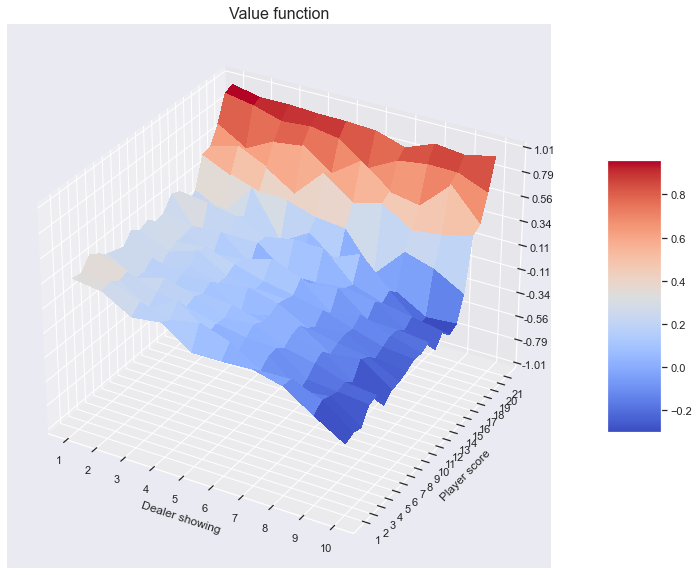

In [12]:
display(mcpol)
plot_table(mcvalue)

## TD learning with SARSA(λ) in Jackblack

You shall now implement the SARSA(λ) algorithm, also using eligibility traces (both accumulating and replacing). Do you expect it will learn a better value function than Monte Carlo? Let's see. For the code below we can re-use some of the functions from the Monte Carlo implementation (but you should pay attention!).

In [29]:
class SARSA():
    
    
    def __init__(self, lamb=.9, N_0=100, n_episodes=100, trace="accumulating"):
        """
        Init the SARSA class with its inner variables.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick") 
        self.lamb = lamb                # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.trace = trace

        self.Q = self.init_to_zeros()                    # init Q function to zeros
        self.N = self.init_to_zeros()                    # init the counter traces to zeros
        self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros

        
    def learn_q_value_function(self):
        """
        Update the Q-function over all the episodes.
        
        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros
            env = Jackblack()                                # init a game sequence
            state = env.state.copy()                         # init state    
            action = self.e_greedy_policy(state)             # pick a first action
            self.increment_counter(state, action)
            
            done = False
            while not done:      
                next_state, reward, done = deepcopy(env.step(action))
                
                if done:
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    
                else:   
                    next_action = self.e_greedy_policy(next_state)   
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    self.increment_counter(next_state, next_action)
                                                
                self.increment_eligibility_traces(state, action)
                self.update_step(delta)
                
                action = next_action
                state = next_state
            
        return self.Q 

    
    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table

    
    def update_step(self, delta):  # TODO9
        """
        Update the Q value towards the target, and also the eligibility traces.
        Implement the correct procedure to update the Q-function and the eligibility traces, with given delta.
        Recall that here traces have already been accumulated/replaced, so there is no need to take care of that.
        
        Parameters
        ----------
        delta : float, the TD error for the current state-action pair
        """
        # Here is where the lambda parameter intervenes. The higher, the slower the eligibility trace
        # associated to a state-action will fade away.
        # YOUR CODE HERE
        # iterating over the state action couples and updating the q value function using delta
        alpha=0.07
        for state in self.Q:
            for action in self.actions:
                self.Q[state][action] += alpha*delta*self.eligibilty_traces[state][action]
                self.eligibilty_traces[state][action] = self.eligibilty_traces[state][action]*self.lamb
    
    def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Compute delta, the TD error.
        
        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the (e_greedy) policy
        
        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        if next_action is None:
            delta = reward - self.Q[lookup_state][action]
        else:
            next_lookup_state = tuple(next_state.values())
            delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
        return delta
    
    
    def increment_eligibility_traces(self, state, action):  # TODO10
        """
        Replace or accumulate the active trace.
        To choose between accumulating or replacing traces, query the corresponding inner variable of the class,
        and implement the update accordingly.
        You just need to accumulate or replace, the "fading" is taken into account in <update_step>!
        
        Parameters
        ----------
        state : dict, active state
        action : string, active action
        """
        # YOUR CODE HERE
        lookup_state = tuple(state.values())

        # updating the eligibility traces according to the chosen method
        if self.trace == "accumulating":
            self.eligibilty_traces[lookup_state][action] += 1
        elif self.trace == "replacing":
            self.eligibilty_traces[lookup_state][action] = 1
        else:
            raise NotImplementedError()

        
    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1
        
    
    def random_policy(self):  # TODO11
        """
        Return an action following a random policy (clearly state free).
        
        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        # Returning random action
        return np.random.choice(self.actions)

    
    def e_greedy_policy(self, state):  # TODO12
        """
        Return an action given an epsilon greedy policy.
        
        Parameters
        ----------
        state : dict, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        # epsilon is defined using the parameter N_0 and the number of times we went through the state 
        eps = self.N_0/(self.N_0+self.get_state_counter(state))
        # selecting the best action based on state-action Q value
        best_action = self.get_action_w_max_value(state)
        # returning the best action or the other one according to probability eps
        return np.random.choice([best_action,np.setxor1d([best_action], self.actions)[0]], p=[1-eps,eps])
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.
        
        Parameters
        ----------
        state : dict, state for the Q-function
        
        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action

        
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Parameters
        ----------
        state : dict or tuple with values
        
        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))
        
        return counter

    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Parameters
        ----------
        state : dict or tuple with values
        action : string
        
        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]
        
        return counter     
    
    
    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.
        
        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
        
        return max_Q, df_pivot

In [30]:
# AT THIS POINT THE SARSA CLASS MUST BE COMPLETED!

Now let's play 50_000 episodes and learn the Q-function with the SARSA algorithm!

In [31]:
sarsa = SARSA(n_episodes=50_000)
sarsa.learn_q_value_function();
sarsavalue, sarsapol = sarsa.optimal_policy()

Display the results!

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,hit,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
6,hit,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,hit,stick
9,hit,stick,stick,stick,stick,stick,stick,stick,hit,stick


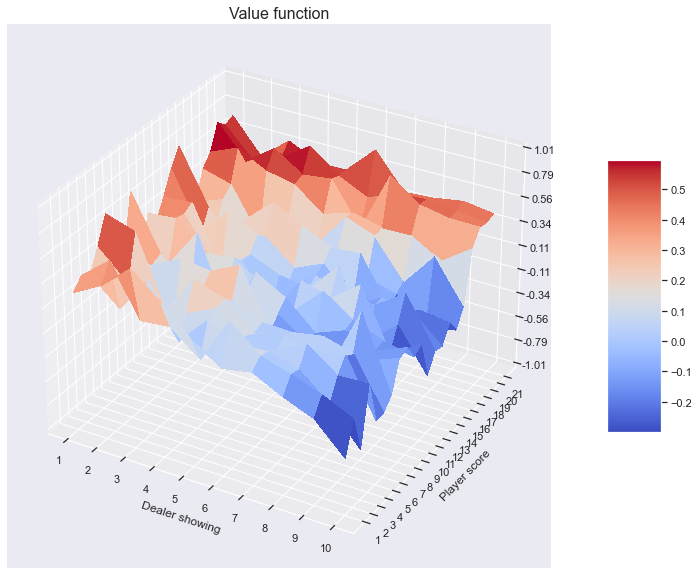

In [32]:
display(sarsapol)
plot_table(sarsavalue)

## Linear Value Approximation in Jackblack

Even if our environment is not that complicated, and has a very limited number of states and actions, introducing a linear approximation for the Q-function may be beneficial, especially if we restrict the number of episode to 50_000 (which is not that high).

In the code below you shall implement the linear value approximation of the SARSA(λ) algorithm, where features are overlapped! In particular, the tile coding for the player's sum is made of 6 features; each feature is active if the state lies in between the 2 values (extremes included):

$(1, 6), \ (4, 9), \ (7, 12), \ (10, 15), \ (13, 18), \ (16, 21)$

As you see, there are some states in which there is more than one active feature.

In [27]:
class Value_Approximation():
    
    
    def __init__(self, lamb=.9, epsilon=0.05, n_episodes=100, lr=0.01, trace="accumulating"):
        """
        Init the SARSA approximation class with its inner variables.
        Features are created with the given function.
        Here the epsilon and learning rate parameters are given explicitly and fixed.
        Initial weights for the linear function approximation are sampled from a Gaussian.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick") 
        self.lamb = lamb                                  # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes                      # number of episodes (games) to sample in order to make the agent learn
        self.trace = trace
        
        self.features = self.create_features()                        # make features
        self.n_features = len(self.features)
        self.theta = self.init_theta()                                # init theta randomly
        self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros
                
        self.alpha = lr
        self.epsilon = epsilon
        
        # Only used for plot in optimal policy
        self.Q = self.init_to_zeros()

        
    def learn_q_value_function(self):  # TODO13
        """
        Update the Q-function (i.e. the weights!) towards the target, and also the eligibility traces.
        This function always considers the epsilon greedy policy.
        Compute delta with the function below (to be implemented).
        Both the updates of the weights and eligibility traces are taken into account in <update_step>. Use it!
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros
            env = Jackblack()                                             # init a game sequence
            state = env.state.copy()                                      # init state    
            action = self.e_greedy_policy(state)                          # pick a first action
            
            # YOUR CODE HERE
            # here the code for sarsa-lambda was basically repeated since the update is done in the same way
            # except that here is done on the weights
            done = False
            while not done:      
                next_state, reward, done = deepcopy(env.step(action))
                
                if done:
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                else:   
                    next_action = self.e_greedy_policy(next_state)   
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                                                
                self.update_step(delta,state,action)
                
                action = next_action
                state = next_state
                
    
    def init_theta(self):
        """
        Init the weights of the approximation function from a normal centered reduced gaussian distribution
        
        Returns
        ----------
        theta : nd-array, random weights for the approximation
        """
        
        mu, sigma = 0, 0.1 # mean and standard deviation
        theta = np.random.normal(mu, sigma, self.n_features)
        return theta

    
    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table

    
    def create_features(self):
        """
        Create the features for linear function approximation. Overlapping tile coding.
        
        Returns
        ----------
        features : list of tuples, each tuple is a combination of features (dealer_feature, player_feature, action)
        """
        
        dealer = [(1, 4), (4, 7), (7, 10)]
        player = [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)]  # Overlapping features!
        actions = ["hit", "stick"]
        features = []
        for d in dealer:
            for p in player:
                for a in actions:
                    features.append((d, p, a))
        return features

    
    def update_step(self, delta, state, action):  # TODO14
        """
        Update the weights of the linear function towards the optimality, and also the eligibility traces. 
        According to the inner variable of the class, implement the correct version of the trace.
        Here you need to accumulate or replace, but also to implement the "fading" mechanism!
        
        Parameters
        ----------
        delta : float, the TD error for the given state-action pair
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= lookup_state[0] <= feature[0][1]) and \
               (feature[1][0] <= lookup_state[1] <= feature[1][1]) and \
               (action == feature[2]):                
                index_associated_features.append(i)

        # Update eligibility traces here! Both accumulating and replacing version.
        # YOUR CODE HERE

        for feature in index_associated_features:
            # updating eligibility traces according to the chosen trace
            if self.trace == "accumulating":
                self.eligibilty_traces[feature] += 1
            elif self.trace == "replacing":
                self.eligibilty_traces[feature] = 1
            else:
                raise NotImplementedError()

            # updating linear model parameters according to algorithm formula
            self.theta[feature] += self.alpha*delta*self.eligibilty_traces[feature]

            # if any action is done we also have to update eligibility traces
            if action != None:
                self.eligibilty_traces[feature]*=self.lamb

    
    def compute_delta(self, state, action, next_state, next_action, reward):  # TODO15
        """
        Compute delta, the TD error, with function approximation! You need to use phi (which is given)!
        Recall the formula of the TD error under function approximation.
        
        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the policy
        
        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        # YOUR CODE HERE

        # Defining delta according to the chosen action
        if next_action is None:
            delta = reward - self.phi(lookup_state,action)
        else:
            next_lookup_state = tuple(next_state.values())
            delta = reward + self.phi(next_lookup_state,next_action) - self.phi(lookup_state,action)
        return delta        
    

    def phi(self, state, action):
        """
        The linear function phi, which compute the Q-value for a given state-action pair. Implements tile coding.
        
        Parameters
        ----------
        state : tuple, the current state
        action : string, the current action
        
        Returns
        ----------
        q_value: float, the q value associated to a given state-action pair.
        
        """
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= state[0] <= feature[0][1]) and \
               (feature[1][0] <= state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)
        q_value = np.sum(np.take(self.theta, index_associated_features, axis=0))
        
        return q_value   
    
    
    def random_policy(self):  # TODO16
        """
        Return an action following a random policy (clearly state free).
        
        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        # returning random action
        return np.random.choice(self.actions)

    
    def e_greedy_policy(self, state):  # TODO17
        """
        Return an action given an epsilon greedy policy.
        
        Parameters
        ----------
        state : dict, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        # selecting the action based on state-action Q value
        best_action = self.get_action_w_max_value(state)
        return np.random.choice([best_action,np.setxor1d([best_action], self.actions)[0]], p=[1-self.epsilon,self.epsilon])
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.
        
        Parameters
        ----------
        state : dict, state for the Q-function
        
        Returns
        ----------
        action : string, best action for the state according to the approximated Q-function
        """
        try:
            lookup_state = tuple(state.values())
        except AttributeError:
            lookup_state = state
        if self.phi(lookup_state, "hit") == self.phi(lookup_state, "stick"):
            return self.random_policy()
        else:
            if self.phi(lookup_state, "hit") > self.phi(lookup_state, "stick"):
                return "hit"
            else:
                return "stick"
        

    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.
        Note the use of phi!
        
        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = self.get_action_w_max_value(states[i])
            max_Q[states[i][1]-1][states[i][0]-1] = self.phi(states[i], best_action)
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
        
        return max_Q, df_pivot

In [28]:
# AT THIS POINT THE SARSA WITH APPROXIMATION CLASS MUST BE COMPLETED!

Now let's play 50_000 episodes and learn the approximated Q-function with the SARSA algorithm with function approximation!

In [29]:
va = Value_Approximation(n_episodes=50_000)
va.learn_q_value_function()
vavalue, vapol = va.optimal_policy()

Display the results!

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit
8,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit
9,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit


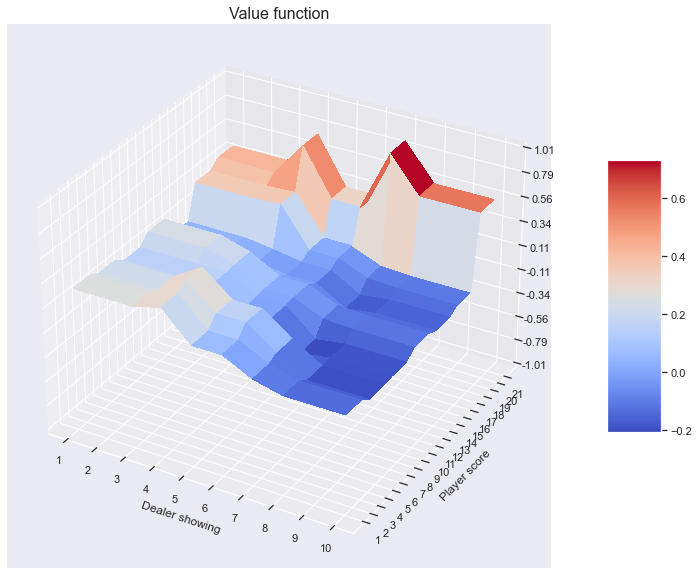

In [30]:
display(vapol)
plot_table(vavalue)

### TODO18
Comment the results you obtained with the three different procedures with regard to the optimal policy, the value-function and the computational burden. Do not describe the results, but try to say meaningful things about _why_ you obtained such results.
You do not need more than 7-10 lines.

Answer in the cell below.

# Comments

# Monte-Carlo Control

Monte-Carlo control seems to be the most stable approach between the used ones given the fact that it does not make use of bootstrap but instead consider the full episodes states and actions. The shape of the Q-value function appears to be well-defined with the highest value associated to the states in which the player hase already won (score=21), while it is lower for states in which the player has a low score or the dealer has a high value showing card.

For what concerns the optimal policy it seems that the best action in the most cases is to stick. This is probably due to the implementation of Jackblack, infact for a lot of cases, in particular when the player's score is low it may be risky to draw a card that may have a high value and reduce the player's score to a value lower than 1. If instead the player has a score higher than 10 the risk is the opposite since he may draw a card that would put the output higher than 21. The only case in which the hit action may be useful is when the dealer shown card has a high value and so it's worth to take the risk in order to overcome his hidden score.